## Logistic regression

We want to minimize
$$\min_{x\in {\mathbb R}^{d}} f(x)=-\frac{1}{n}\sum_{i=1}^n \left(y_i \log (s(a_i^\top x)) + (1 - y_i) \log (1 - s(a_i^\top x))\right) + \frac{\ell_2}{2}\|x\|^2,$$
where  $a_i\in {\mathbb R}^{d}$, $y_i\in \{0, 1\}$, $s(z)=\frac{1}{1+\exp(-z)}$ is the sigmoid function.
The gradient is given by $\nabla f(x) = \frac{1}{n}\sum_{i=1}^n a_i(s(a_i^\top x)-y_i) + \ell_2 x$.

This is a smooth function with smoothness constant $L=\frac{1}{4}\lambda_{\max}(X^\top X) + \ell_2$, where $\lambda_{\max}$ denotes the largest eigenvalue.

For this experiment we used mushrooms and covtype datasets from the LibSVM library. Since the former is smaller and hence runs faster, we use it below.

In [1]:
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import numpy.linalg as la
from sklearn.datasets import load_svmlight_file

from optimizers import Gd, Nesterov, Adgd, AdgdAccel, Adagrad
from loss_functions import logistic_loss, logistic_gradient

sns.set(style="whitegrid", context="talk", palette=sns.color_palette("bright"), color_codes=False)
data_path = './datasets/mushrooms'

it_max = 3000

def logistic_smoothness(X):
    return 0.25 * np.max(la.eigvalsh(X.T @ X / X.shape[0]))


data = load_svmlight_file(data_path)
X, y = data[0].toarray(), data[1]
if (np.unique(y) == [1, 2]).all():
    # Loss functions support only labels from {0, 1}
    y -= 1
n, d = X.shape
L = logistic_smoothness(X)
l2 = L / (10 * n)
w0 = np.zeros(d)

def loss_func(w):
    return logistic_loss(w, X, y, l2)

def grad_func(w):
    return logistic_gradient(w, X, y, l2)

In [2]:
gd = Gd(lr=1 / L, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
gd.run(w0=w0)

In [3]:
nest = Nesterov(lr=1 / L, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
nest.run(w0=w0)

In [4]:
nest_str = Nesterov(lr=1 / L, strongly_convex=True, mu=l2, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
nest_str.run(w0=w0)

In [5]:
adgd = Adgd(loss_func=loss_func, grad_func=grad_func, eps=0, it_max=it_max)
adgd.run(w0=w0)

In [6]:
adgdl = Adgd(loss_func=loss_func, grad_func=grad_func, eps=1 / L ** 2, it_max=it_max)
adgdl.run(w0=w0)

In [7]:
ad_acc = AdgdAccel(loss_func=loss_func, grad_func=grad_func, it_max=it_max)
ad_acc.run(w0=w0)

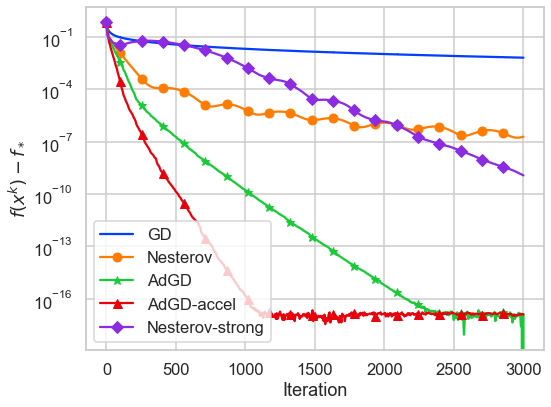

In [12]:
optimizers = [gd, nest, adgd, ad_acc, nest_str]
markers = [',', 'o', '*', '^', 'D', 's', '.', 'X']

for opt, marker in zip(optimizers, markers):
    opt.compute_loss_on_iterates()
f_star = np.min([np.min(opt.losses) for opt in optimizers])

plt.figure(figsize=(8, 6))
labels = ['GD', 'Nesterov', 'AdGD', 'AdGD-accel', 'Nesterov-strong']
for opt, marker, label in zip(optimizers, markers + ['.', 'X'], labels):
    opt.plot_losses(marker=marker, f_star=f_star, label=label)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$f(x^k) - f_*$')
plt.legend()
plt.tight_layout()
# plt.show()
plt.savefig('../ada_step/plots/for_paper/logistic_mushrooms.pdf', dpi=300)

Text(0, 0.5, '$\\lambda_k$')

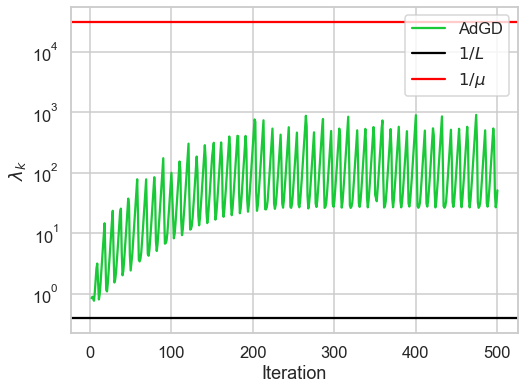

In [13]:
adgd = Adgd(loss_func=loss_func, grad_func=grad_func, eps=0, it_max=500)
adgd.run(w0=w0)
plt.figure(figsize=(8, 6))
my_green = sns.color_palette('bright')[2]
plt.plot(adgd.its[2:], adgd.lrs[2:], label='AdGD', color=my_green)
plt.axhline(y=1 / L, color='black', label='$1/L$')
plt.axhline(y=1 / l2, color='red', label='$1/\mu$')
plt.yscale('log')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('$\lambda_k$')
# plt.savefig('../ada_step/plots/for_paper/logistic_mushrooms_lr.pdf', dpi=300)

## Other methods

In [8]:
etas = np.logspace(-3, 3, 20)
losses = []
#tune the stepsize
for eta in etas:
    adagrad = Adagrad(eta=eta, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
    adagrad.run(w0=w0)
    adagrad.compute_loss_on_iterates()
    print(eta, adagrad.losses[-1])
    losses.append(adagrad.losses[-1])
eta_best = etas[np.nanargmin(losses)]
adagrad = Adagrad(eta=eta_best, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
adagrad.run(w0=w0)

0.001 0.41207045271794174
0.00206913808111479 0.27957586406118806
0.004281332398719396 0.16568268977118866
0.008858667904100823 0.08642263839900778
0.018329807108324356 0.04070758742517006
0.0379269019073225 0.01807065957942967
0.07847599703514611 0.00908650563990449
0.1623776739188721 0.006786353354925088
0.3359818286283781 0.006337880072671529
0.6951927961775606 0.00608097389695302
1.438449888287663 0.005935226978349277
2.976351441631316 0.00589384195072424
6.158482110660261 0.0058456155958071685
12.742749857031322 0.005826655397712524
26.366508987303554 0.005826914564219132
54.555947811685144 0.005912245824497514
112.88378916846884 0.008515489936435878
233.57214690901213 0.34959964658548237
483.2930238571752 0.41886421457138534
1000.0 3.3509028845851634
